## Filtering of Hasubanan alkaloids

In [2]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Lipinski import HeavyAtomCount
from rdkit.Chem.Scaffolds import MurckoScaffold

from tqdm import tqdm

In [3]:
import os
import sys

BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(BASE_PATH)

from src.utils import count_nitrogen_atoms

In [4]:
HERE = Path.cwd().parent

chembl = pd.read_csv(HERE / "data" / "processed" / "chembl_35_NP_cleaned.csv")
chembl.head(2)

,chembl_id,taut_smiles
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C


In [15]:
HERE = Path.cwd().parent

coconut = pd.read_csv(HERE.parent / "compound_collections" / "coconut_08_25.csv")
coconut.head(2)

,identifier,canonical_smiles,name,synonyms
0,CNP0561918.0,O=C1C=CC(=C2OC3=CC(O)=CC(OC4OC(COC(=O)CC(=O)O)...,"3-oxo-3-[[3,4,5-trihydroxy-6-[7-hydroxy-2-(4-o...",NaN
1,CNP0133715.0,OC1=CC=CC=C1CNC1C2COC(O2)C(N2C=CN=C2)C1O,NaN,NaN


In [5]:
hasubanan = {
    "hasubanan": "C2C[C@]14CCCC[C@@]4(CCN1)c3ccccc23",
}

In [6]:
scaffolds_smiles = set()
for smi in hasubanan.values():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    Chem.RemoveStereochemistry(mol)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    # if HeavyAtomCount(scaffold) < 16:
    #     continue
    scaffold_smi = Chem.MolToSmiles(scaffold)
    if scaffold_smi not in scaffolds_smiles:
        scaffolds_smiles.add(scaffold_smi)

In [7]:
scaffolds_smiles

{'c1ccc2c(c1)CCC13CCCCC21CCN3'}

In [12]:
def contain_min_scaffold(mol):
    if any(mol.HasSubstructMatch(Chem.MolFromSmiles(query)) for query in scaffolds_smiles):
        return True
    return False

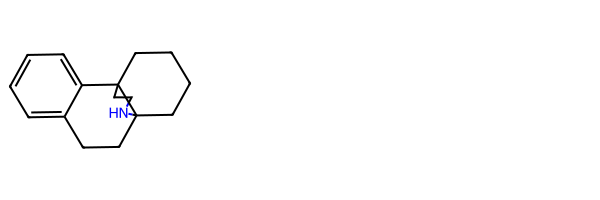

In [10]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in scaffolds_smiles])

In [13]:
hasubanan_in_chembl = []
for i, row in tqdm(chembl.iterrows(), total=len(chembl)):
    mol = Chem.MolFromSmiles(row["taut_smiles"])
    if contain_min_scaffold(mol):
        hasubanan_in_chembl.append(i)

print(len(hasubanan_in_chembl))

100%|██████████| 78163/78163 [00:30<00:00, 2595.93it/s]

11


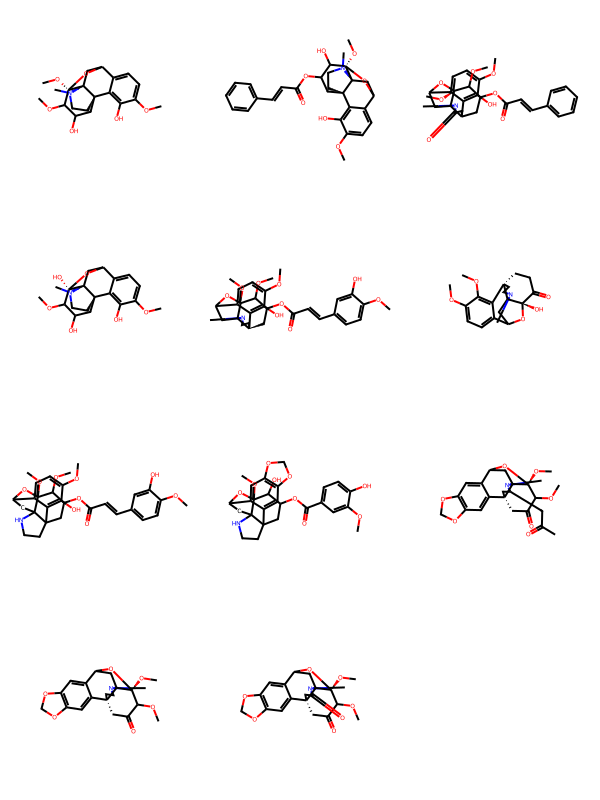

In [14]:
mols = [Chem.MolFromSmiles(s) for s in chembl.loc[hasubanan_in_chembl, "taut_smiles"]]
Draw.MolsToGridImage(mols)

In [17]:
hasubanan_in_coconut = []
for i, row in tqdm(coconut.iterrows(), total=len(coconut)):
    mol = Chem.MolFromSmiles(row["canonical_smiles"])
    if mol is not None:
        if contain_min_scaffold(mol):
            hasubanan_in_coconut.append(i)

print(len(hasubanan_in_coconut))

  8%|▊         | 80074/1061261 [00:33<06:50, 2390.66it/s][12:14:08] WARNING: not removing hydrogen atom without neighbors
[12:14:08] WARNING: not removing hydrogen atom without neighbors
 24%|██▍       | 253557/1061261 [01:49<05:49, 2310.27it/s][12:15:24] WARNING: not removing hydrogen atom without neighbors
[12:15:24] WARNING: not removing hydrogen atom without neighbors
 70%|██████▉   | 741878/1061261 [05:16<02:09, 2470.39it/s][12:18:52] WARNING: not removing hydrogen atom without neighbors
[12:18:52] WARNING: not removing hydrogen atom without neighbors
[12:18:52] WARNING: not removing hydrogen atom without neighbors
 85%|████████▍ | 900016/1061261 [06:31<01:59, 1346.04it/s][12:20:06] WARNING: not removing hydrogen atom without neighbors
[12:20:06] WARNING: not removing hydrogen atom without neighbors
[12:20:06] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 1061261/1061261 [07:44<00:00, 2283.62it/s]

118


In [18]:
coconut.iloc[hasubanan_in_coconut]["identifier"].to_csv(HERE / "data" / "Hasubanan.csv",
                                                        index=False)